# Applying ART evasion, attacks and defences on image ResNet50 pre-trained DNN (Deep Neural network)

## In this notebook we will see :
    1 - how to work with a Keras image classifier in ART
    2 - how ART actually abstracts from the specific ML/DL backend
    3 - how to apply a Projected Gradient Descent (PGD) evasion attack against that classifier
    4 - how to deploy defences against such attacks
    5 - how to create adversarial samples that can bypass those defences

In [1]:
# Load prerequisites

!pip install --upgrade --user adversarial-robustness-toolbox
!pip install --upgrade --user numpy==1.16.4
!pip install --upgrade --user keras==2.2.4
!pip install --upgrade --user matplotlib==3.1.0


     |████████████████████████████████| 378kB 13.2MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 15.2MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: autoai-libs 1.10.3 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Requirement already up-to-date: keras==2.2.4 in /opt/conda/envs/Python36/lib/python3.6/site-packages (2.2.4)
     |████████████████████████████████| 13.1MB 15.9MB/s eta 0:00:01


In [2]:
# Load basic dependencies:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np

# Install ImageNet stubs
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

  Cloning https://github.com/nottombrown/imagenet_stubs to /home/dsxuser/.tmp/pip-req-build-gwsd9b11
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /home/dsxuser/.tmp/pip-req-build-gwsd9b11
  Stored in directory: /home/dsxuser/.tmp/pip-ephem-wheel-cache-oab8lbwl/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


In [3]:
# Load Keras dependencies:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image

# Load ART dependencies:
from art.classifiers import KerasClassifier
from art.attacks import *
from art.defences import *
from art.utils import to_categorical

Using TensorFlow backend.


In [4]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)

images = np.array(images_list)
# The images all have a resolution of 224 x 224 pixels, and 3 color channels (RGB).

images_number = images.shape[0]
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


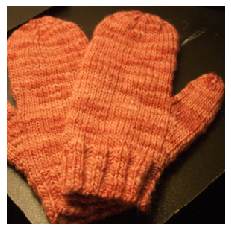

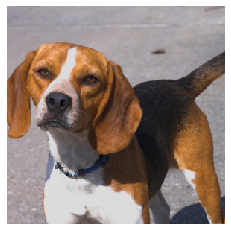

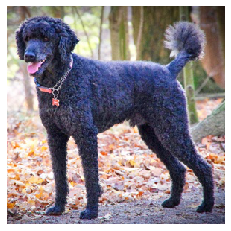

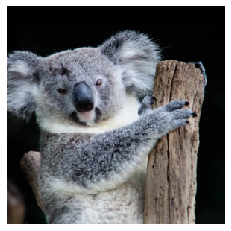

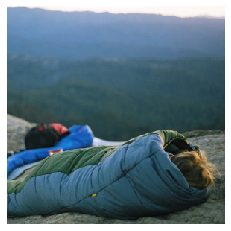

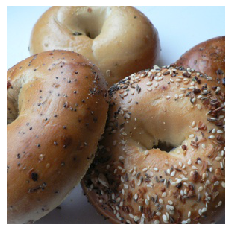

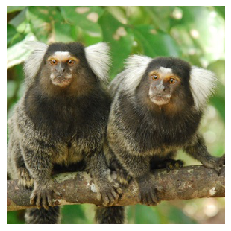

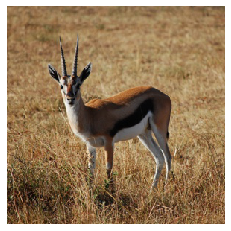

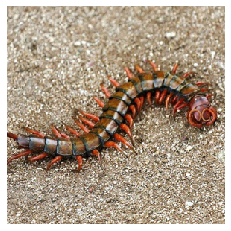

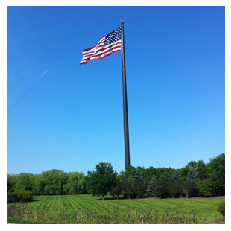

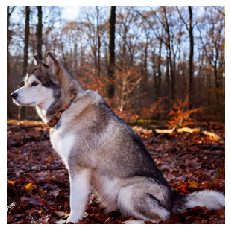

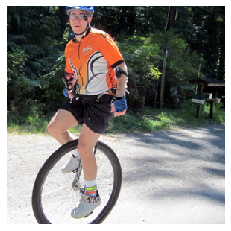

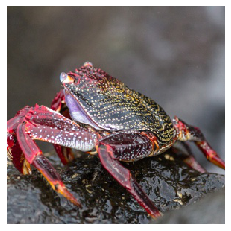

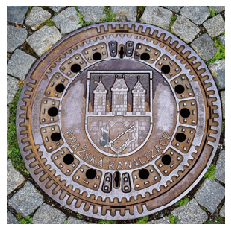

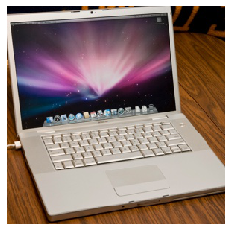

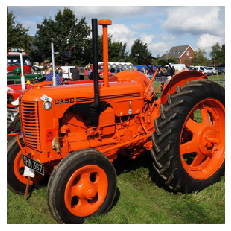

In [5]:
# As default choice, we are going to use the last image (idx = 15) for illustration purposes. 
# But you could use any other of the 16 images in the following (just change the value of the idx variable).

idx = 2

for indx in range(0,images_number):
    plt.figure(figsize=(4,4)); plt.imshow(images[indx] / 255);
    plt.axis('off');
plt.show()

In [6]:
# This loads the pretrained ResNet50 model:
model = ResNet50(weights='imagenet')

# Let's look at the prediction that this model yields for the selected image:

Instructions for updating:
Colocations handled automatically by placer.
102858752/102853048 [==============================] - 1s 0us/step


In [7]:
# We need to expand the input dimension and apply the preprocessing required for ResNet50:
x = np.expand_dims(images[idx].copy(), axis=0)
x = preprocess_input(x)

# Then apply the model, determine the predicted label and confidence:
pred = model.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

# So the model correctly tells us that this image shows a notebook computer, which is good :-)

# Next we will create an ART KerasClassifier wrapper around the model. 
# We need to take care of the preprocess_input logic that has to be applied:

# swap the order of the color channels (RGB -> BGR)
# subtract the channel means

Prediction: standard poodle - confidence 0.95


In [8]:
# Provide the channel means as input for the ART KerasClassifier:
mean_imagenet = np.array([103.939, 116.779, 123.68])

# Create the classifier wrapper:
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=(mean_imagenet, 1))

# Now we will apply the classifier object to obtain the prediction.

# Note: we have to swap the color channel order (from RGB to BGR) before feeding the input to the classifier

# Same as for the original model, we expand the dimension of the inputs.
# We also swap the color channels (RGB -> BGR):
x_art = np.expand_dims(images[idx], axis=0)[..., ::-1] 

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

# So through the classifier API we obtain the same predictions as from the raw model, but now we have an abstraction from the actual backend (e.g. Keras).

# The classifier wrapper allows us to call other functions besides predict.

# For example, we can obtain the loss gradient of the classifier, which is used in many of the algorithms for adversarial sample generation:

Instructions for updating:
Use tf.cast instead.
Prediction: standard poodle - confidence 0.95


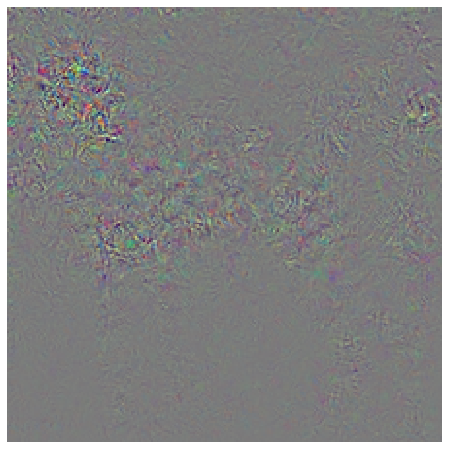

In [9]:
loss_gradient = classifier.loss_gradient(x=x_art, y=to_categorical([label], nb_classes=1000))

# Let's plot the loss gradient. 
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient[0][..., ::-1] 

# Then normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8)); plt.imshow(loss_gradient_plot); plt.axis('off'); plt.show()

Create adversarial samples¶

Next, we are going to create an adversarial sample. 
We are going to use Projected Gradient Descent (PGD), which is one of the strongest existing attacks. 
We will first perform an untargeted adversarial attack.

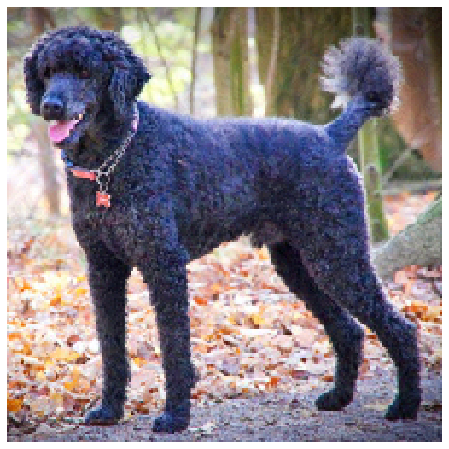

Prediction: toy poodle - confidence 0.98


In [10]:
# Create the attacker:
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0][..., ::-1] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Next, we will perform a targeted attack where we pick the class that we want the classifier to predict on the adversarial sample. 
Below is the list of labels and class names - make your pick!

In [11]:
for i in range(1000):
    print('label', i, '-', label_to_name(i))

label 0 - tench, Tinca tinca
label 1 - goldfish, Carassius auratus
label 2 - great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
label 3 - tiger shark, Galeocerdo cuvieri
label 4 - hammerhead, hammerhead shark
label 5 - electric ray, crampfish, numbfish, torpedo
label 6 - stingray
label 7 - cock
label 8 - hen
label 9 - ostrich, Struthio camelus
label 10 - brambling, Fringilla montifringilla
label 11 - goldfinch, Carduelis carduelis
label 12 - house finch, linnet, Carpodacus mexicanus
label 13 - junco, snowbird
label 14 - indigo bunting, indigo finch, indigo bird, Passerina cyanea
label 15 - robin, American robin, Turdus migratorius
label 16 - bulbul
label 17 - jay
label 18 - magpie
label 19 - chickadee
label 20 - water ouzel, dipper
label 21 - kite
label 22 - bald eagle, American eagle, Haliaeetus leucocephalus
label 23 - vulture
label 24 - great grey owl, great gray owl, Strix nebulosa
label 25 - European fire salamander, Salamandra salamandra
label 26 

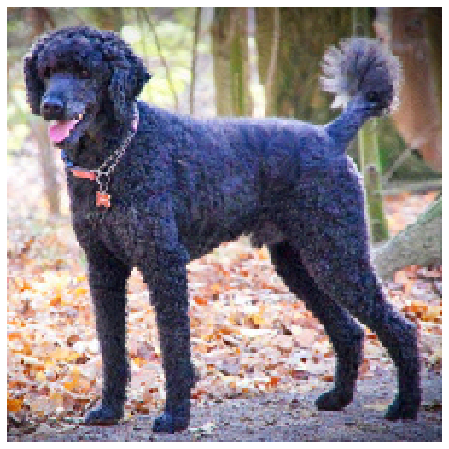

Prediction: catamaran - confidence 1.00


In [12]:
# As default, let's get this image misclassified as catamaran (label 484)!
target_label = 484
# Now let's perform the targeted attack:

# Set the configuration to a targeted attack:
adv.set_params(targeted=True)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0][..., ::-1] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

We can measure the quantity of perturbation that was added to the image using different ℓp
ℓ
p
 norms. 
Note: the PGD attack controls the ℓ∞
ℓ
∞
 norm via the epsilon parameter.

Perturbation l_0 norm: 82%
Perturbation l_1 norm: 3%
Perturbation l_2 norm: 3%
Noise l_inf norm: 2%


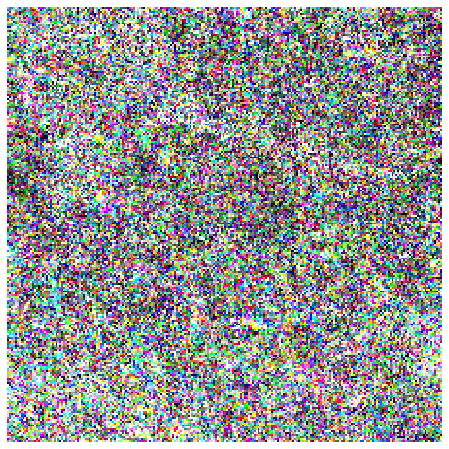

In [13]:
# We can measure the quantity of perturbation that was added to the image using different lp norms. 

l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv[0])>0.5)[0]) / (224*224*3)) + 1   
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv[0]) / np.linalg.norm(x_art[0])) + 1 
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv[0])) / 255) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

# Let's also plot the absolute amount of adversarial pixel perturbations:
pert = np.abs(x_art[0] - x_art_adv[0])[..., ::-1]
pert_min = np.min(pert)
pert_max = np.max(pert)
plt.figure(figsize=(8,8)); plt.imshow((pert - pert_min) / (pert_max - pert_min)); plt.axis('off'); plt.show()


Apply defences

Next we are going to apply a simple input preprocessing defence: Spatial Smoothing. 
Ideally, we want this defence to result in correct predictions when applied both to the original and the adversarial images.


Prediction of original sample: standard poodle - confidence 0.80
Prediction of adversarial sample: standard poodle - confidence 0.32


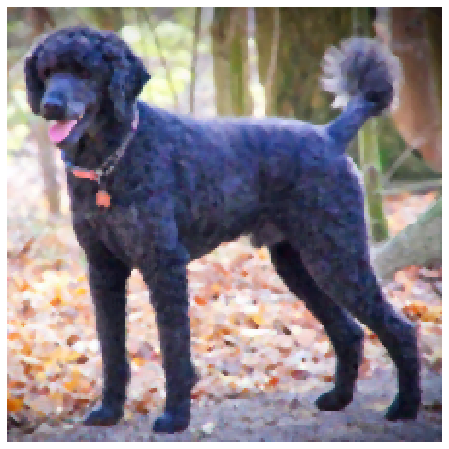

In [14]:
# Initalize the SpatialSmoothing defence. 
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = ss(x_art)
x_art_adv_def, _ = ss(x_art_adv)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def), 
      '- confidence {0:.2f}'.format(confidence_adv_def))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()

Perform adaptive whitebox attack to defeat defences

**Next we are going to mount an adaptive whitebox attack in which the attacker aims at defeating the defence that we just put into place.**

First, we create a classifier which incorporates the defence:

In [16]:
classifier_def = KerasClassifier(defences=[ss], clip_values=(0, 255), 
                                 model=model, preprocessing=(mean_imagenet, 1))

# Now we apply this classifier to the adversarial sample from before:
pred_def = classifier_def.predict(x_art_adv)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

print('Prediction:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))

# We observe that this classifier reproduces the prediction that we had obtained before by manually applying the input preprocessing defence.

# Now we create an adversarial sample against the defended classifier. 
# As we are going to see, this adversarial sample is able to bypass the input preprocessing defence.

Prediction: standard poodle - confidence 0.32


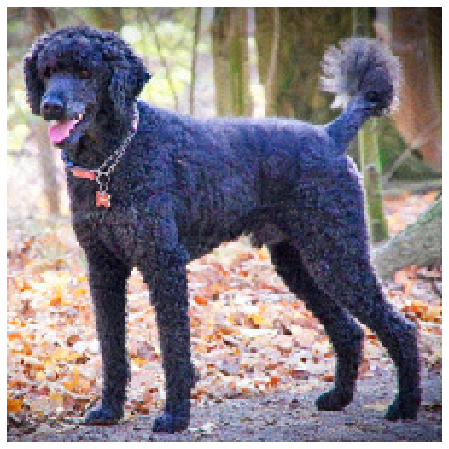

Prediction: catamaran - confidence 1.00


In [17]:
# Create the attacker.
# Note: here we are using a stronger attack (larger number of iterations) in order to defeat the defence
adv_def = ProjectedGradientDescent(classifier_def, targeted=True, max_iter=40, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0][..., ::-1] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier_def.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

In [18]:
l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv_def[0])>0.5)[0]) / (224*224*3)) + 1   
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv_def[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv_def[0]) / np.linalg.norm(x_art[0])) + 1 
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv_def[0])) / 255) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

Perturbation l_0 norm: 95%
Perturbation l_1 norm: 4%
Perturbation l_2 norm: 3%
Noise l_inf norm: 2%


Comparing with the previous adversarial sample, the ℓ0
ℓ
0
 and ℓ1
ℓ
1
 norms have slightly increased, while ℓ2
ℓ
2
 and ℓ∞
ℓ
∞
 norms have stayed the same (the latter not being surprising as the PGD attack controls the ℓ∞
ℓ
∞
 norm budget).

**Conclusion**

We have walked through an end-to-end example of using a Keras image classifier in ART, creating adversarial samples, deploying input preprocessing defences and, finally, bypassing those defences in an adaptive white-box attack.

IBM copyright


Jean-Luc Collet

https://www.linkedin.com/in/jean-luc-collet